In [1]:
import os
os.chdir('..')

from sparse_coding_torch.sparse_model import SparseCode, ReconSparse
import tensorflow.keras as keras
from sparse_coding_torch.utils import plot_video, plot_filters, plot_filters_image
from IPython.display import HTML
import tensorflow as tf

In [2]:
vae = keras.models.load_model('sparse_coding_torch/ptx/vae_output/best_encoder.pt/')

2022-08-11 14:54:36.291285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 14:54:36.293216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 14:54:36.295044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 14:54:36.296878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 14:54:36.306981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

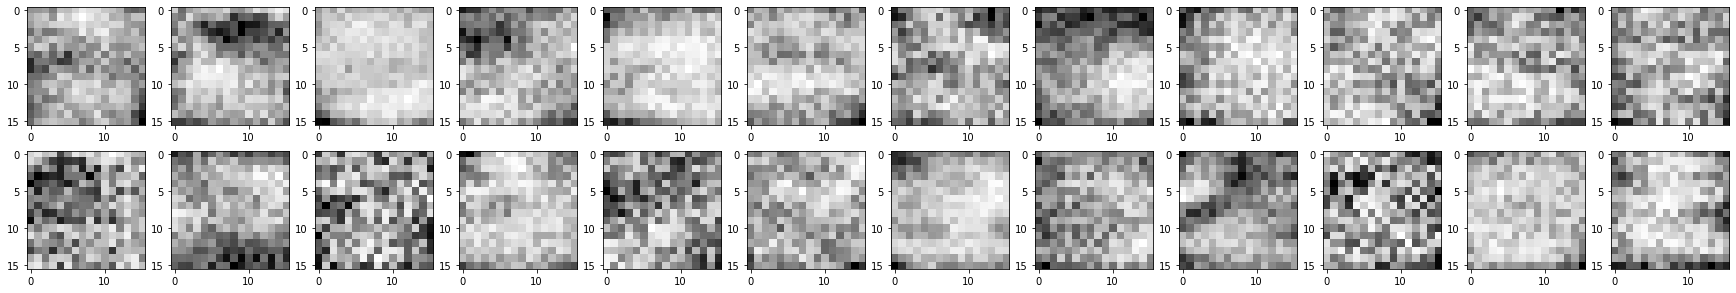

In [4]:
ani = plot_filters_image(vae.get_weights()[0])
ani.savefig("/home/dwh48@drexel.edu/sparse_coding_torch/sparse_coding_torch/ptx/vae_output/filters.eps")

In [9]:
image_height = 285
image_width = 400
clip_depth = 5
batch_size = 1
kernel_size = 15
kernel_depth = 5
num_kernels = 48
stride=4
max_activation_iter = 150
activation_lr=1e-2
lam=0.05
run_2d=False
sparse_checkpoint = 'sparse_coding_torch/output/48_ptx/best_sparse.pt/'

In [10]:
inputs = keras.Input(shape=(5, image_height, image_width, 1))
        
filter_inputs = keras.Input(shape=(5, kernel_size, kernel_size, 1, num_kernels), dtype='float32')

output = SparseCode(batch_size=batch_size, image_height=image_height, image_width=image_width, clip_depth=clip_depth, in_channels=1, out_channels=num_kernels, kernel_size=kernel_size, kernel_depth=kernel_depth, stride=stride, lam=lam, activation_lr=activation_lr, max_activation_iter=max_activation_iter, run_2d=run_2d)(inputs, filter_inputs)

sparse_model = keras.Model(inputs=(inputs, filter_inputs), outputs=output)

# recon_model = keras.models.load_model(sparse_checkpoint)

recon_inputs = keras.Input(shape=(1, (image_height - kernel_size) // stride + 1, (image_width - kernel_size) // stride + 1, num_kernels))
    
recon_outputs = ReconSparse(batch_size=batch_size, image_height=image_height, image_width=image_width, clip_depth=clip_depth, in_channels=1, out_channels=num_kernels, kernel_size=kernel_size, kernel_depth=kernel_depth, stride=stride, lam=lam, activation_lr=activation_lr, max_activation_iter=max_activation_iter, run_2d=run_2d)(recon_inputs)

recon_model = keras.Model(inputs=recon_inputs, outputs=recon_outputs)

recon_model.set_weights(keras.models.load_model(sparse_checkpoint).get_weights())

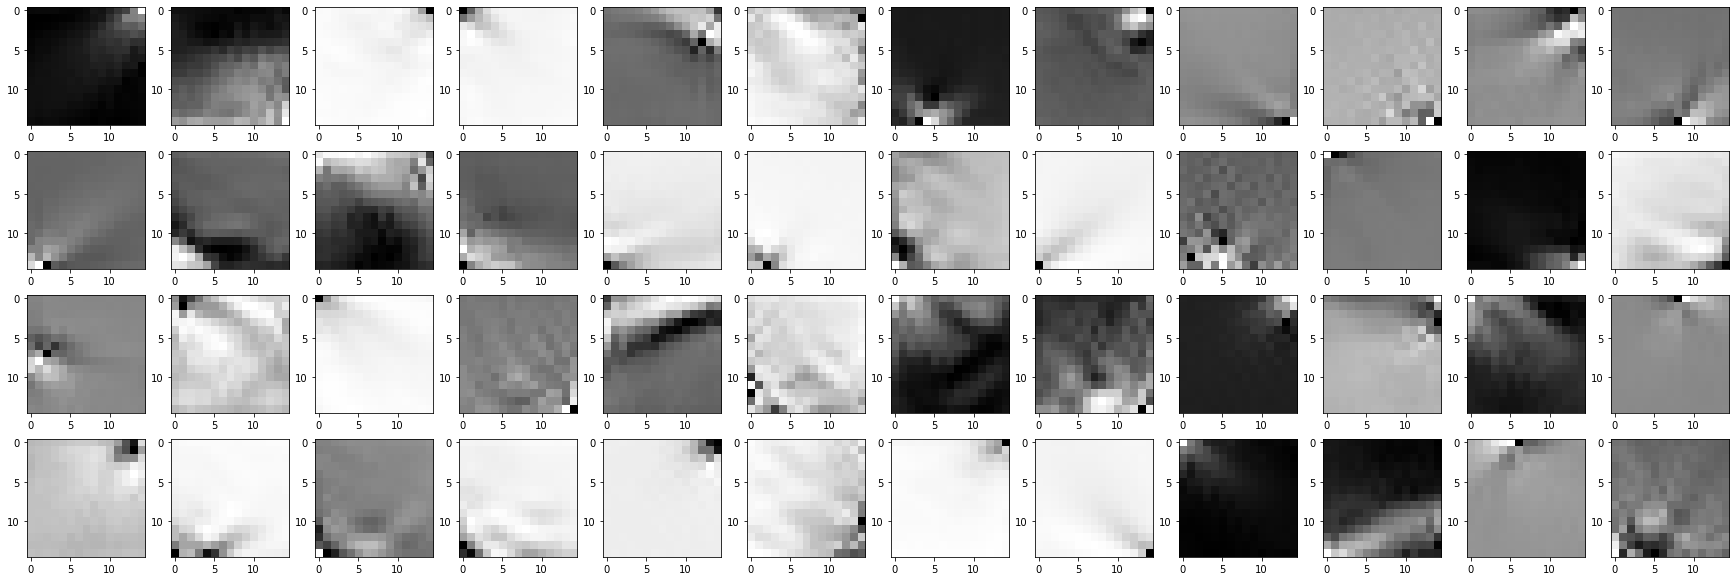

In [12]:
# ani = plot_filters(recon_model.get_weights()[0])
# HTML(ani.to_html5_video())
ani = plot_filters_image(recon_model.get_weights()[0])
ani.savefig("/home/dwh48@drexel.edu/sparse_coding_torch/sparse_coding_torch/output/48_ptx/filters.eps")

In [ ]:
import torch
splits, dataset = load_pnb_videos(yolo_model, 1, input_size=(image_height, image_width, clip_depth), crop_size=(image_height, image_width, clip_depth), classify_mode=True, balance_classes=False, mode='default', device=None, n_splits=1, sparse_model=None, frames_to_skip=1)
train_idx, test_idx = list(splits)[0]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
# train_sampler = SubsetWeightedRandomSampler(get_sample_weights(train_idx, dataset), train_idx, replacement=True)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                       sampler=train_sampler)

test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                       sampler=test_sampler)

In [ ]:
pos_label, pos_clip, vid = next(iter(train_loader))
neg_label, neg_clip, vid = next(iter(train_loader))
print(pos_label)
print(neg_label)
ani = plot_video(neg_clip.squeeze(0))
HTML(ani.to_html5_video())

In [ ]:
clip = neg_clip.permute(0, 2, 3, 4, 1).numpy()
activations = sparse_model([clip, tf.expand_dims(recon_model.trainable_weights[0], axis=0)])
recon = recon_model(activations)
ani = plot_video(recon)
HTML(ani.to_html5_video())

In [ ]:
all_negative_activations = []
all_positive_activations = []

for label, clip, vid in train_loader:
    clip = clip.permute(0, 2, 3, 4, 1).numpy()
    activations = sparse_model([clip, tf.expand_dims(recon_model.trainable_weights[0], axis=0)])
    if label[0] == 'Negatives':
        all_negative_activations.append(activations)
    else:
        all_positive_activations.append(activations)

print(len(all_negative_activations))
print(len(all_positive_activations))

In [ ]:
all_negative_activations = tf.reshape(tf.stack(all_negative_activations), (-1, 64))
all_positive_activations = tf.reshape(tf.stack(all_positive_activations), (-1, 64))

negative_scores = tf.math.reduce_sum(all_negative_activations, axis=0)
negative_scores = negative_scores / tf.math.reduce_max(negative_scores)
positive_scores = tf.math.reduce_sum(all_positive_activations, axis=0)
positive_scores = positive_scores / tf.math.reduce_max(positive_scores)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].bar(range(len(negative_scores)), negative_scores)
ax[1].bar(range(len(positive_scores)), positive_scores)


plt.tight_layout()
plt.show()

In [ ]:
largest_diff = int(tf.math.argmax(tf.math.abs(positive_scores - negative_scores)))
print(largest_diff)

In [ ]:
def plot_filter(video):

    fig = plt.gcf()
    ax = plt.gca()

    DPI = fig.get_dpi()
#     fig.set_size_inches(video.shape[2]/float(DPI), video.shape[3]/float(DPI))

    ax.set_title("Video")

    T = video.shape[1]
    im = ax.imshow(video[0, 0, :, :],
                     cmap=cm.Greys_r)

    def update(i):
        t = i % T
        im.set_data(video[0, t, :, :])

    return FuncAnimation(plt.gcf(), update, interval=1000/20)

In [ ]:
filter_diff = recon_model.trainable_weights[0][:, :, :, :, 4]
filter_diff = tf.expand_dims(tf.squeeze(filter_diff, -1), 0)
print(filter_diff.shape)
ani = plot_filter(filter_diff)
# HTML(ani.to_html5_video())
ani.save("/home/dwh48@drexel.edu/sparse_coding_torch/sparse_coding_torch/output/sparse_pnb_48/needle_filter.mp4")

In [ ]:
label, clip, vid = list(train_loader)[1]
clip = clip.permute(0, 2, 3, 4, 1).numpy()
ani = plot_video(clip)
# HTML(ani.to_html5_video())
ani.save("/home/dwh48@drexel.edu/sparse_coding_torch/sparse_coding_torch/output/sparse_pnb_48/needle_video.mp4")

In [ ]:
activations = sparse_model([clip, tf.expand_dims(recon_model.trainable_weights[0], axis=0)])[:, :, :, :, 4]
ani = plot_video(activations)
# HTML(ani.to_html5_video())
ani.save("/home/dwh48@drexel.edu/sparse_coding_torch/sparse_coding_torch/output/sparse_pnb_48/activation_map.mp4")